Normal ECG
(3641, 187) (405, 187)
Abnormal ECG
(3641, 187) (405, 187)
(7282, 187) (810, 187)
(7282, 1) (810, 1)
(100, 187)
(75,)


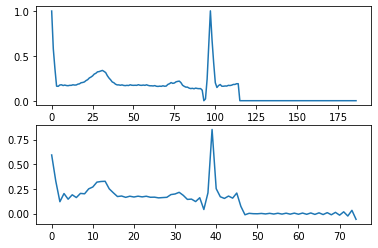

In [11]:

import numpy as np
import wfdb
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as scp
from scipy import signal

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    # else:
    #     data = [wfdb.rdsamp(path+f) for f in df.filename_hr
    data = np.array([signal for signal, meta in data])
    return data

path = '/content/'
sampling_rate=100

# Y = pd.read_csv('/content/ptbdb_abnormal.csv', index_col='ecg_id')
# # Ypos = Y.loc[Y['scp_codes'].str.contains("{'NORM': 100.0}") == True]
# Ypos = Y.loc[Y['scp_codes'].str.contains("{'SARRH':") == True]

# # Load raw signal data
# X = load_raw_data(Ypos, sampling_rate, path)
# print(X.shape)
# X2chan = np.squeeze(X[:,:,1])
# scp.savemat("data.mat",{'data':X2chan})

ptb = pd.read_csv('/home/alan/winDesktop/ARM_ECG/simulation/ptbdb_normal.csv',header = None)
ptb_ab = pd.read_csv('/home/alan/winDesktop/ARM_ECG/simulation/ptbdb_abnormal.csv',header = None)
print('Normal ECG')
norm = np.array(ptb.iloc[:,:187])

norm_training, norm_test = norm[:int(0.9*norm.shape[0]),:],norm[int(0.9*norm.shape[0]):,:]
print(norm_training.shape, norm_test.shape)
print('Abnormal ECG')
abnorm = np.array(ptb_ab.iloc[:4046,:187])
abnorm_training, abnorm_test = abnorm[:int(0.9*abnorm.shape[0]),:],abnorm[int(0.9*abnorm.shape[0]):,:]
print(abnorm_training.shape, abnorm_test.shape)
x_training = np.vstack((norm_training,abnorm_training))
x_test = np.vstack((norm_test,abnorm_test))
print(x_training.shape,x_test.shape)
y_training_pos = np.ones((norm_training.shape[0],1))
y_training_neg = np.zeros((abnorm_training.shape[0],1))
y_training = np.vstack((y_training_pos,y_training_neg))

y_test_pos = np.ones((norm_test.shape[0],1))
y_test_neg = np.zeros((abnorm_test.shape[0],1))
y_test = np.vstack((y_test_pos,y_test_neg))

print(y_training.shape,y_test.shape)
# np.save("testdata_neg.npy",x_test[500,:])
romtest = np.vstack((x_test[0:50,:],x_test[405:455,:]))
print(romtest.shape)
# np.save("romtestcase.npy",romtest)
plt.subplot(211)
plt.plot(x_test[0,:])
plt.subplot(212)
x_test_100 = signal.resample(x_test[0,:],75)
plt.plot(x_test_100)
print(x_test_100.shape)

In [14]:
import struct
def binary(num):
    # Struct can provide us with the float packed into bytes. The '!' ensures that
    # it's in network byte order (big-endian) and the 'f' says that it should be
    # packed as a float. Alternatively, for double-precision, you could use 'd'.
    packed = struct.pack('!f', num)
    # print 'Packed: %s' % repr(packed)

    # For each character in the returned string, we'll turn it into its corresponding
    # integer code point
    # 
    # [62, 163, 215, 10] = [ord(c) for c in '>\xa3\xd7\n']
    integers = [c for c in packed]
    # print 'Integers: %s' % integers

    # For each integer, we'll convert it to its binary representation.
    binaries = [bin(i) for i in integers]
    # print 'Binaries: %s' % binaries

    # Now strip off the '0b' from each of these
    stripped_binaries = [s.replace('0b', '') for s in binaries]
    # print 'Stripped: %s' % stripped_binaries

    # Pad each byte's binary representation's with 0's to make sure it has all 8 bits:
    #
    # ['00111110', '10100011', '11010111', '00001010']
    padded = [s.rjust(8, '0') for s in stripped_binaries]
    # print 'Padded: %s' % padded

    # At this point, we have each of the bytes for the network byte ordered float
    # in an array as binary strings. Now we just concatenate them to get the total
    # representation of the float:
    return ''.join(padded)

In [2]:
from keras import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.utils.vis_utils import plot_model

model = Sequential([
    Dense(5, input_shape=(187,)),
    Activation('relu'),
    Dense(10),
    Activation('relu'),
    Dense(15),
    Activation('relu'),
    Dense(30),
    Activation('relu'),
    Dense(15),
    Activation('relu'),
    Dense(10),
    Activation('relu'),
    # Dense(5),
    # Activation('relu'),
    Dense(1),
    Activation('sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# history = model.fit(x_training, y_training, batch_size=32, epochs=60)
weights = np.load('/home/alan/winDesktop/ARM_ECG/simulation/weight.npy',allow_pickle=True)
model.set_weights(weights)


Using TensorFlow backend.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 940       
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                60        
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                165       
_________________________________________________________________
activation_3 (Activation)    (None, 15)                0         
_________________________________________________________________
dense_4 (Dense)             

In [3]:
weights = model.get_weights() # returs a numpy list of weights
weightnp0 = np.array(weights[0])
print(weightnp0.shape)
input_layer = pd.DataFrame(weightnp0)
print(input_layer.head())
np.save("weight.npy",weights)

(187, 5)
          0         1         2         3         4
0 -0.189813  0.251062 -0.067027  0.166019  0.106136
1  0.397006  0.050480 -0.365868  0.471219  0.030376
2  0.048319 -0.109957  0.232143 -0.581208 -0.030235
3 -0.373925 -0.070593 -0.150956 -0.500182  0.186778
4 -0.185198  0.498962  0.105767 -0.560471  0.064751


In [27]:
from keras import Model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print(f"Model output: {model.predict(np.expand_dims(x_test[500 ,:],axis =0 ))} \n\n")

# fig, axes = plt.subplots(2,1)
# axes[0].plot(history.history['accuracy'])
# axes[0].set_title('Model Accuracy')
# axes[0].set_ylabel('Accuracy')
# axes[0].set_xlabel('Epoch')

# fig.subplots_adjust(hspace=1)

# axes[1].plot(history.history['loss'], 'g')
# axes[1].set_title('Model Loss')
# axes[1].set_ylabel('Cross Entropy Loss')
# axes[1].set_xlabel('Epoch')

for j in range(1,8):
    print(f"Keras simulation on activation layer {j} ==> \n ")
    intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(f"activation_{j}").output)
    intermediate_output = intermediate_layer_model.predict(np.expand_dims(x_test[500 ,:],axis =0 ))
    Rintermediate_output = np.squeeze(intermediate_output,axis=0)
    # print(Rintermediate_output.shape)
    for i in range(len(Rintermediate_output)):
        print(f"Output{i}: Decimal:{Rintermediate_output[i]:.16f} \t Float Binary: {binary(Rintermediate_output[i])}")
    print(f"\n------------END LAYER {j}--------------\n")



Test loss: 0.1936160883417836
Test accuracy: 0.9209876656532288
Model output: [[0.00294659]] 


Keras simulation on activation layer 1 ==> 
 
Output0: Decimal:0.7652800083160400 	 Float Binary: 00111111010000111110100101100100
Output1: Decimal:0.2218970656394958 	 Float Binary: 00111110011000110011100011111100
Output2: Decimal:0.7452118396759033 	 Float Binary: 00111111001111101100011000110100
Output3: Decimal:0.5250436663627625 	 Float Binary: 00111111000001100110100101000011
Output4: Decimal:0.4649358987808228 	 Float Binary: 00111110111011100000110000010100

------------END LAYER 1--------------

Keras simulation on activation layer 2 ==> 
 
Output0: Decimal:0.1150033995509148 	 Float Binary: 00111101111010111000011011100111
Output1: Decimal:1.0452818870544434 	 Float Binary: 00111111100001011100101111001100
Output2: Decimal:0.0000000000000000 	 Float Binary: 00000000000000000000000000000000
Output3: Decimal:0.0000000000000000 	 Float Binary: 00000000000000000000000000000000
Output4

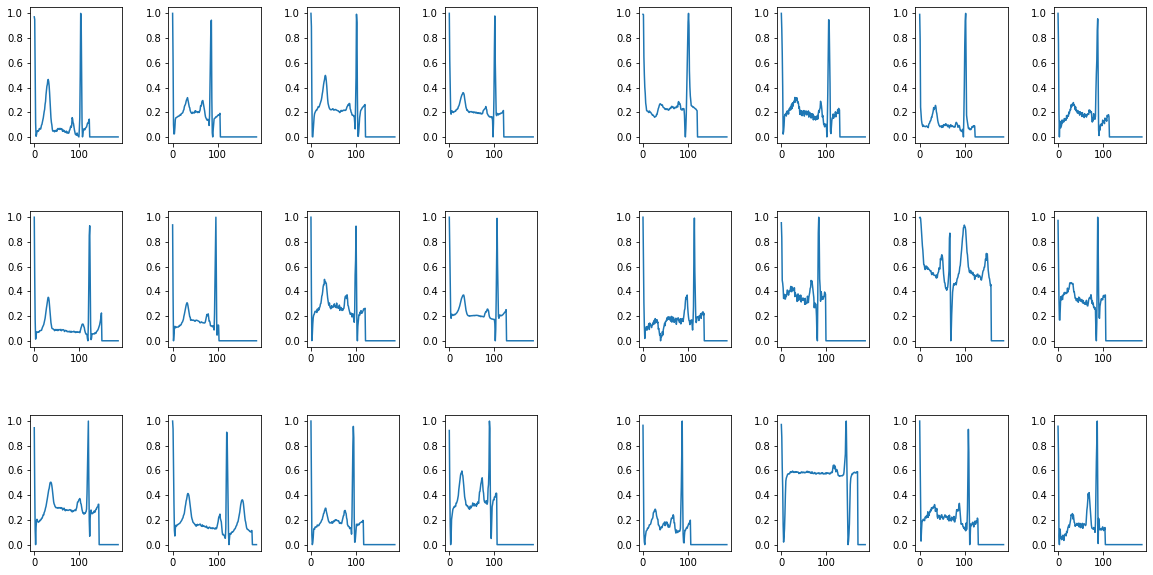

In [0]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(20, 10))
outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)

for i in range(2):
    inner = gridspec.GridSpecFromSubplotSpec(3, 4,
                    subplot_spec=outer[i], wspace=0.5, hspace=0.5)

    for j in range(12):
        ax = plt.Subplot(fig, inner[j])
        # t = ax.text(0.5,0.5, 'outer=%d, inner=%d' % (i,j))
        # t.set_ha('center') 
        # ax.set_xticks([])
        # ax.set_yticks([])
        if i==0:
            ax.plot(x_test[375+j])
        else:
            ax.plot(x_test[405+j])
        fig.add_subplot(ax)

fig.show()